# Initialization 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


##### IMPORT ALL USED LIBRARIES HERE TO AVOID REDUNDANCY

### Random Forests ###
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

### Linear Regression ###
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression

### CART ###
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def OSR2(model, X_test, y_test, y_train):
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
    return (1 - SSE/SST)

def OSR2_no_model(y_pred, y_test, y_train):
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
    return (1 - SSE/SST)

def MSE(model, X_test, y_test, y_train):
    y_pred = model.predict(X_test)
    mse = np.mean((y_test-y_pred)**2)
    return mse

def MSE_no_model(y_pred, y_test):
    mse = np.mean((y_test-y_pred)**2)
    return mse

def MAE(model, X_test, y_test, y_train):
    y_pred = model.predict(X_test)
    mae = np.mean(np.abs(y_test-y_pred))
    return mae

def MAE_no_model(y_pred, y_test):
    mae = np.mean(np.abs(y_test-y_pred))
    return mae

def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

# adapted from StackOverflow
# https://stackoverflow.com/questions/62490392/how-to-apply-log-on-negative-values-based-upon-some-conditions-in-python
def findlog(n):
    if n > 0:
        log = np.log(n)
    elif n < 0:
        log = -np.log(-n)
    elif n == 0:
        log = 0
    return log

# Data Loading

In [ ]:
# reads data and removes whitespace from column names

data_filename = "clean_data.csv"
data = pd.read_csv(data_filename)
data = data.rename(columns={col:col.replace(' ', '') for col in data.columns}) # removes whitespace from column names
data

,Accession#,DataDate,CIK,Company,FiscalYear,Ticker,TotalAssets,ShortTermAssets,TotalLiabilities&StockholderEquity,ShortTermLiabilities,NetIncome,OutstandingShares,MarketPrice(Monthavg.),MarketCap
0,0000950123-09-057827,2009-09-30,804328,QUALCOMM INC/DE,2009,QCOM,27445000000,12570000000,27445000000,2813000000,1592000000,1669000000,33.51,55928190000
1,0000950123-09-063897,2009-09-30,1024478,ROCKWELL AUTOMATION INC,2009,ROK,4305700000,2134800000,4305700000,947200000,220700000,141600000,33.31,4716696000
2,0000950123-09-064772,2009-09-30,829224,STARBUCKS CORP,2009,SBUX,5576800000,2035800000,5576800000,1581000000,390800000,742900000,8.24,6121496000
3,0000950123-09-066012,2009-09-30,1140859,AMERISOURCEBERGEN CORP,2009,ABC,13572740000,9953753000,13572740000,9479610000,503397000,287922263,18.11,5214272182
4,0000950123-09-066095,2009-09-30,2969,AIR PRODUCTS & CHEMICALS INC /DE/,2009,APD,13029100000,2997800000,13029100000,2503600000,631300000,209900000,52.88,11099512000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23421,0001819790-21-000010,2020-12-31,1819790,"TARSUS PHARMACEUTICALS, INC.",2020,TARS,171972000,170655000,171972000,5387000,-26811000,20323201,36.89,749722884
23422,0001820721-21-000009,2020-12-31,1820721,"ARRAY TECHNOLOGIES, INC.",2020,ARRY,656024000,375175000,656024000,289103000,59073000,121467000,39.89,4845318630
23423,0001829126-21-001412,2020-12-31,1341766,"CELSIUS HOLDINGS, INC.",2020,CELH,131289773,93150665,131289773,26365092,8523849,72262829,39.22,2834148153
23424,0001829126-21-001487,2020-11-30,1813603,HESTIA INSIGHT INC.,2020,HSTA,12110718,12088765,12110718,24730,11524462,27910200,9.00,251191800


# Creation of Log Data

In [ ]:
#creates logdata DataFrame

logdata = pd.DataFrame()
log_columns = ['MarketCap', 'TotalAssets', 'ShortTermAssets', 'TotalLiabilities&StockholderEquity', 'ShortTermLiabilities', 'NetIncome']
for col in log_columns:
  logdata[col] = data[col].apply(findlog) # data appears exponential therefore decided natural log was best for linear estimation

#need this for train/test split
logdata['FiscalYear'] = data['FiscalYear']
logdata

,MarketCap,TotalAssets,ShortTermAssets,TotalLiabilities&StockholderEquity,ShortTermLiabilities,NetIncome,FiscalYear
0,24.747334,24.035450,23.254579,24.035450,21.757517,21.188257,2009
1,22.274374,22.183206,21.481639,22.183206,20.669021,19.212315,2009
2,22.535072,22.441881,21.434155,22.441881,21.181323,19.783706,2009
3,22.374665,23.331329,23.021216,23.331329,22.972409,20.036890,2009
4,23.130167,23.290451,21.821145,23.290451,21.640996,20.263292,2009
...,...,...,...,...,...,...,...
23421,20.435214,18.962842,18.955155,18.962842,15.499499,-17.104323,2020
23422,22.301279,20.301708,19.742903,20.301708,19.482294,17.894285,2020
23423,21.765007,18.692917,18.349729,18.692917,17.087551,15.958379,2020
23424,19.341727,16.309601,16.307787,16.309601,10.115772,16.259982,2020


In [ ]:
logdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23426 entries, 0 to 23425
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   MarketCap                           23426 non-null  float64
 1   TotalAssets                         23426 non-null  float64
 2   ShortTermAssets                     23426 non-null  float64
 3   TotalLiabilities&StockholderEquity  23426 non-null  float64
 4   ShortTermLiabilities                23426 non-null  float64
 5   NetIncome                           23426 non-null  float64
 6   FiscalYear                          23426 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 1.3 MB


# VIF

In [ ]:
VIF(logdata, ['TotalAssets', 'ShortTermAssets', 'TotalLiabilities&StockholderEquity', 'ShortTermLiabilities', 'NetIncome'])


TotalAssets                           209.733549
ShortTermAssets                        13.437045
TotalLiabilities&StockholderEquity    199.839675
ShortTermLiabilities                    4.893982
NetIncome                               1.378618
dtype: float64

In [ ]:
# removing 'Total Assets" since this has the largest VIF value
VIF(logdata, ['ShortTermAssets',
       'TotalLiabilities&StockholderEquity', 'ShortTermLiabilities',
       'NetIncome'])

ShortTermAssets                       12.956573
TotalLiabilities&StockholderEquity    14.366831
ShortTermLiabilities                   4.866165
NetIncome                              1.377775
dtype: float64

In [ ]:
#removing 'Total Liabilities & Stockholder Equity'
VIF(logdata, ['ShortTermAssets', 'ShortTermLiabilities', 'NetIncome'])

ShortTermAssets         4.189627
ShortTermLiabilities    4.345957
NetIncome               1.368474
dtype: float64

In [ ]:
#All VIF values below 5 with these features
low_VIF_features = ['ShortTermAssets', 'NetIncome', 'ShortTermLiabilities']
lowVIF_data = logdata[low_VIF_features + ['FiscalYear', 'MarketCap']]
lowVIF_data

,ShortTermAssets,NetIncome,ShortTermLiabilities,FiscalYear,MarketCap
0,23.254579,21.188257,21.757517,2009,24.747334
1,21.481639,19.212315,20.669021,2009,22.274374
2,21.434155,19.783706,21.181323,2009,22.535072
3,23.021216,20.036890,22.972409,2009,22.374665
4,21.821145,20.263292,21.640996,2009,23.130167
...,...,...,...,...,...
23421,18.955155,-17.104323,15.499499,2020,20.435214
23422,19.742903,17.894285,19.482294,2020,22.301279
23423,18.349729,15.958379,17.087551,2020,21.765007
23424,16.307787,16.259982,10.115772,2020,19.341727


# Data Spliting

In [ ]:
# Train Test split
# Using data prior to and including 2018 as training data and data after 2018 for testing (makes a 3:1 train test split)

train = data[data["FiscalYear"] <= 2018]
test = data[data["FiscalYear"] > 2018]

#USING lowVIF NOT all logdata
logtrain = lowVIF_data[lowVIF_data["FiscalYear"] <= 2018]
logtest = lowVIF_data[lowVIF_data["FiscalYear"] > 2018]

logtrain.shape, logtest.shape

((18044, 5), (5382, 5))

In [ ]:
# LINEAR DATA (original data types)
X_train = train.drop(['MarketCap', 'FiscalYear'], axis=1)
y_train = train['MarketCap']

X_test = test.drop(['MarketCap', 'FiscalYear'], axis=1)
y_test = test['MarketCap']

# LOG TRANSFORMED DATA WITH 3 FEATURES
logX_train = logtrain.drop(['MarketCap', 'FiscalYear'], axis=1)
logy_train = logtrain['MarketCap']

logX_test = logtest.drop(['MarketCap', 'FiscalYear'], axis=1)
logy_test = logtest['MarketCap']

logX_train.shape, logX_test.shape


((18044, 3), (5382, 3))

# CART

In [ ]:
# Copying data to build CART model
cart_x_train = logX_train.copy()#.drop("Fiscal Year", axis=1) # Fiscal Year dropped in initial train-test split cell
cart_y_train = logy_train.copy()

cart_x_test = logX_test.copy()#.drop("Fiscal Year", axis=1) # Fiscal Year dropped in initial train-test split cell
cart_y_test = logy_test.copy()

In [ ]:
# Training the CART Model with log-log data
grid_values = {'ccp_alpha': np.linspace(0, 0.10, 51)}

dtr = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)
cv = KFold(n_splits=5, random_state=1, shuffle=True)
log_dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='r2', cv=cv, verbose=0)
log_dtr_cv.fit(cart_x_train, cart_y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=20,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=88, s...
             param_grid={'ccp_alpha': array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
       0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
       0.036, 0.038, 

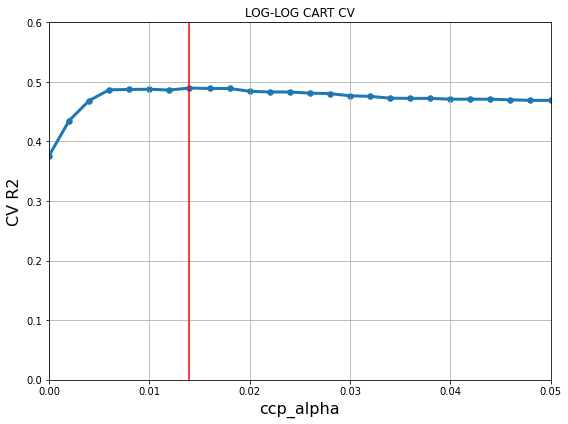

In [ ]:
log_ccp_alpha = log_dtr_cv.cv_results_['param_ccp_alpha'].data
log_R2_scores = log_dtr_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.title("LOG-LOG CART CV")
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(log_ccp_alpha, log_R2_scores, s=30)
plt.plot(log_ccp_alpha, log_R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([0, 0.05])
plt.ylim([0.0, 0.6])
plt.axvline(log_dtr_cv.best_params_['ccp_alpha'], color='red')

plt.tight_layout()
plt.show()

In [ ]:
osr2_cart = OSR2(log_dtr_cv, cart_x_test, cart_y_test, cart_y_train)
mse_cart = MSE(log_dtr_cv, cart_x_test, cart_y_test, cart_y_train)
mae_cart = MAE(log_dtr_cv, cart_x_test, cart_y_test, cart_y_train)


print("LOG-LOG MODEL RESULTS")
print("Best ccp_alpha:", log_dtr_cv.best_params_['ccp_alpha'])
print('Cross-validated R2:', round(log_dtr_cv.best_score_, 5))
print('OSR2:', round(osr2_cart, 5))
print("MAE:", round(mae_cart, 5))
print("MSE:", round(mse_cart, 5))


LOG-LOG MODEL RESULTS
Best ccp_alpha: 0.014
Cross-validated R2: 0.48979
OSR2: 0.65867
MAE: 1.13741
MSE: 2.63753


In [ ]:
# Copying data to train a linear-log CART model
linear_cart_x_train = X_train.copy().loc[:, "TotalAssets":"NetIncome"]
linear_cart_y_train = np.log(y_train)

linear_cart_x_test = X_test.copy().loc[:, "TotalAssets":"NetIncome"]
linear_cart_y_test = np.log(y_test)

In [ ]:
# Training the CART Model with linear-log data
grid_values = {'ccp_alpha': np.linspace(0, 0.05, 51)}

dtr = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)
cv = KFold(n_splits=5, random_state=1, shuffle=True)
linear_dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='r2', cv=cv, verbose=0)
linear_dtr_cv.fit(linear_cart_x_train, linear_cart_y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=20,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=88, s...
             param_grid={'ccp_alpha': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 

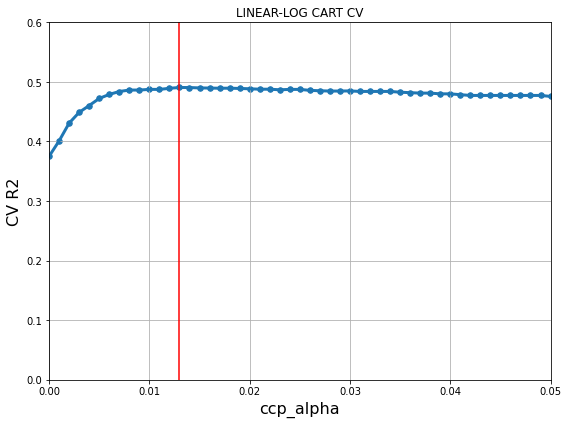

In [ ]:
linear_ccp_alpha = linear_dtr_cv.cv_results_['param_ccp_alpha'].data
linear_R2_scores = linear_dtr_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.title("LINEAR-LOG CART CV")
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(linear_ccp_alpha, linear_R2_scores, s=30)
plt.plot(linear_ccp_alpha, linear_R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([0, 0.05])
plt.ylim([0.0, 0.6])
plt.axvline(linear_dtr_cv.best_params_['ccp_alpha'], color='red')


plt.tight_layout()
plt.show()

In [ ]:
print("LINEAR-LOG MODEL RESULTS")
print("Best ccp_alpha:", linear_dtr_cv.best_params_['ccp_alpha'])
print('Cross-validated R2:', round(linear_dtr_cv.best_score_, 5))
print('OSR2:', round(OSR2(linear_dtr_cv, linear_cart_x_test, linear_cart_y_test, linear_cart_y_train), 5))
print("MAE:", round(MAE(linear_dtr_cv, linear_cart_x_test, linear_cart_y_test, linear_cart_y_train), 5))
print("MSE:", round(MSE(linear_dtr_cv, linear_cart_x_test, linear_cart_y_test, linear_cart_y_train), 5))


LINEAR-LOG MODEL RESULTS
Best ccp_alpha: 0.013000000000000001
Cross-validated R2: 0.49065
OSR2: 0.66114
MAE: 1.13133
MSE: 2.6184


# Linear Regression

In [ ]:
lr_data = lowVIF_data.copy()

In [ ]:
# Renaming The col for Linear Regression
lr_data.rename(columns = {'Market Cap':'MarketCap', 'Total Assets':'TotalAssets',
                              'Short Term Assets':'ShortTermAssets',
                          'Total Liabilities & Stockholder Equity':'TLSE',
                         'Short Term Liabilities':'ShortTermLiabilities','Net Income':'NetIncome'
                          ,'Fiscal Year':'FiscalYear'}, inplace = True)

In [ ]:
lr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23426 entries, 0 to 23425
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ShortTermAssets       23426 non-null  float64
 1   NetIncome             23426 non-null  float64
 2   ShortTermLiabilities  23426 non-null  float64
 3   FiscalYear            23426 non-null  int64  
 4   MarketCap             23426 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 915.2 KB


In [ ]:
#Data Spliting 
lr_train = lr_data[lr_data['FiscalYear'] <= 2018]
lr_test = lr_data[lr_data['FiscalYear'] > 2018]
lr_y_train = lr_train['MarketCap']
lr_y_test = lr_test['MarketCap']

In [ ]:
# Final model
lr_new = smf.ols(formula='MarketCap ~ ShortTermAssets + ShortTermLiabilities+ NetIncome',
                 data=lr_train).fit()
print(lr_new.summary())

                            OLS Regression Results                            
Dep. Variable:              MarketCap   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     4384.
Date:                Wed, 12 May 2021   Prob (F-statistic):               0.00
Time:                        23:01:52   Log-Likelihood:                -39671.
No. Observations:               18044   AIC:                         7.935e+04
Df Residuals:                   18040   BIC:                         7.938e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                8.6377 

In [ ]:
# Evaluating model Performance
def lr_OSR2(model, df_train, df_test, dependent_var):   
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    return 1 - SSE/SST
def lr_MSE(model, df_train, df_test, dependent_var):
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    mse = np.mean((y_test-y_pred)**2)
    return mse

def lr_MAE(model, df_train, df_test, dependent_var):
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    mae = np.mean(np.abs(y_test-y_pred))
    return mae

osr2_lr = lr_OSR2(lr_new, lr_train, lr_test, 'MarketCap')
mse_lr = lr_MSE(lr_new, lr_train, lr_test, 'MarketCap')
mae_lr = lr_MAE(lr_new, lr_train, lr_test, 'MarketCap')

print('Final OSR2: ', osr2_lr)
print('Final MSE: ', mse_lr)
print('Final MAE: ', mae_lr)

Final OSR2:  0.6206168803231846
Final MSE:  2.9315340649972375
Final MAE:  1.2516377139113168


# Random Forest

In [ ]:
# split data into training and testing

rf_y_train = logy_train.copy()
rf_X_train = logX_train.copy()
rf_y_test = logy_test.copy()
rf_X_test = logX_test.copy()
rf_X_train

,ShortTermAssets,NetIncome,ShortTermLiabilities
0,23.254579,21.188257,21.757517
1,21.481639,19.212315,20.669021
2,21.434155,19.783706,21.181323
3,23.021216,20.036890,22.972409
4,21.821145,20.263292,21.640996
...,...,...,...
20865,12.797956,-15.124859,14.643450
21132,10.409190,-14.132044,14.062346
21136,11.094770,-13.743019,14.127922
21250,10.724302,-16.068002,15.667281


In [ ]:
# train Random Forest model

rf = RandomForestRegressor(max_features=3, min_samples_leaf=5, 
                           n_estimators = 500, random_state=88, verbose=2)
rf.fit(rf_X_train, rf_y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   26.7s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=88, verbose=2, warm_start=False)

In [ ]:
#display feature importances

pd.DataFrame({'Feature' : rf_X_train.columns, 
              'Importance score': rf.feature_importances_}).round(3) #This is all excluding the dummy variables for specific company tickers

,Feature,Importance score
0,ShortTermAssets,0.644
1,NetIncome,0.253
2,ShortTermLiabilities,0.104


In [ ]:
#compute OSR^2 of RandomForests Model

osr2_rf = OSR2(rf, rf_X_test, rf_y_test, rf_y_train)
osr2_rf

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished


0.6584777329599901

In [ ]:
#compute MSE and MAE of RandomForests Model

mse_rf = MSE(rf, rf_X_test, rf_y_test, rf_y_train)
mae_rf = MAE(rf, rf_X_test, rf_y_test, rf_y_train)
mae_rf, mse_rf

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished


(1.1176709413979067, 2.6389791950568307)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished


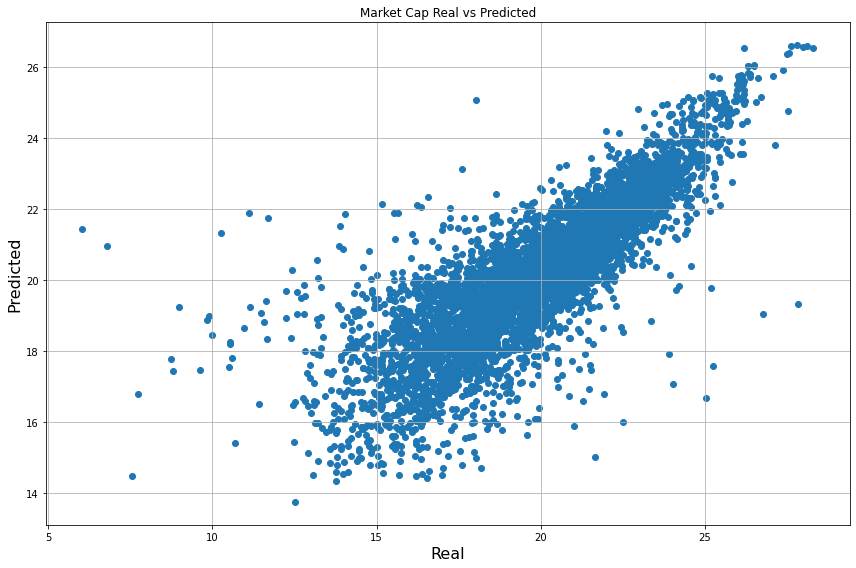

In [ ]:

#adapted from lab 7

plt.figure(figsize=(12, 8))
plt.title('Market Cap Real vs Predicted')
plt.xlabel('Real', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.scatter(rf_y_test, rf.predict(rf_X_test))
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished


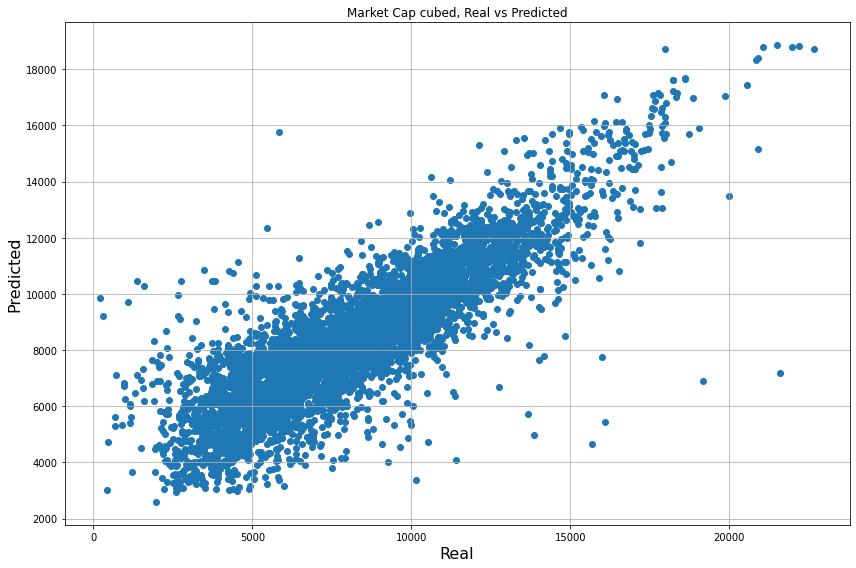

In [ ]:
#Experimental model that exponentiates data to achieve higher OSR^2

plt.figure(figsize=(12, 8))
plt.title('Market Cap cubed, Real vs Predicted')
plt.xlabel('Real', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.scatter(rf_y_test**3, rf.predict(rf_X_test)**3)
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

In [ ]:
# cubing data results in model with higher OSR^2
OSR2_no_model(rf.predict(rf_X_test)**3, rf_y_test**3, rf_y_train**3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished


0.7277841864166512

# Blended Linear Regression

In [ ]:
##### Blended Log-Log

final_LR_model = lr_new
final_CART_model = log_dtr_cv
final_RF_model = rf

In [ ]:
blended_log_df = pd.DataFrame()
blended_log_df['LinearRegressionPrediction'] = final_LR_model.predict(logX_test)
blended_log_df['CARTPrediction'] = final_CART_model.predict(logX_test)
blended_log_df['RandomForestsPrediction'] = final_RF_model.predict(logX_test)
blended_log_df['RealMarketCap'] = logy_test
blended_log_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished


,LinearRegressionPrediction,CARTPrediction,RandomForestsPrediction,RealMarketCap
17488,20.880541,21.012626,20.939949,20.799433
17491,22.253199,22.278932,22.521373,23.269729
17499,21.378889,21.012626,22.054048,22.279842
17505,20.719453,21.012626,20.483946,21.110527
17510,21.822396,21.428629,21.583811,21.361458
...,...,...,...,...
23421,19.253726,20.121355,20.281110,20.435214
23422,21.048961,21.012626,21.408384,22.301279
23423,19.727042,19.348507,19.262176,21.765007
23424,16.258198,18.150295,18.042664,19.341727


In [ ]:
#define blended model and get 

blended_log_model = smf.ols(formula='RealMarketCap ~ LinearRegressionPrediction + CARTPrediction + RandomForestsPrediction', data=blended_log_df).fit()
blended_log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          RealMarketCap   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     4602.
Date:                Wed, 12 May 2021   Prob (F-statistic):               0.00
Time:                        23:02:24   Log-Likelihood:                -9716.7
No. Observations:                5382   AIC:                         1.944e+04
Df Residuals:                    5378   BIC:                         1.947e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -6.2004      0.234    -26.492      0.000      -6.659      -5.742
LinearRegressionPrediction     0.4971      0.028     17.922      0.000       0.443       0.551
CARTPrediction                 0.3919      0.036     10.805      0.000       0.321       0.463
RandomForestsPrediction        0.4040      0.033     12.428      0.000       0.340       0.468
==============================================================================
Omnibus:                     1812.539   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27477.307
Skew:                          -1.191   Prob(JB):                         0.00
Kurtosis:                      13.810   Cond. No.                         410.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Blended model yields: MarketCap = 0.4845*LinearRegression + 0.3681*CART + 0.4381*RandomForests - 6.1544
#R^2 is .720

# using coefficients from above
blended_log_df['BlendedPrediction'] = 0.4845*blended_log_df['LinearRegressionPrediction'] \
                                                + 0.3681*blended_log_df['CARTPrediction'] \
                                                + 0.4381*blended_log_df['RandomForestsPrediction'] \
                                                - 6.1544
blended_log_df

,LinearRegressionPrediction,CARTPrediction,RandomForestsPrediction,RealMarketCap,BlendedPrediction
17488,20.880541,21.012626,20.939949,20.799433,20.870762
17491,22.253199,22.278932,22.521373,23.269729,22.694764
17499,21.378889,21.012626,22.054048,22.279842,21.600298
17505,20.719453,21.012626,20.483946,21.110527,20.592939
17510,21.822396,21.428629,21.583811,21.361458,21.762297
...,...,...,...,...,...
23421,19.253726,20.121355,20.281110,20.435214,19.465855
23422,21.048961,21.012626,21.408384,22.301279,21.157583
23423,19.727042,19.348507,19.262176,21.765007,18.964296
23424,16.258198,18.150295,18.042664,19.341727,16.308312


In [ ]:
#MAE(blended_log_model, logX_test, logy_test, logy_train), MSE(blended_log_model, logX_test, logy_test, logy_train)

mae_blended = MAE_no_model(blended_log_df['BlendedPrediction'], logy_test)
mse_blended = MSE_no_model(blended_log_df['BlendedPrediction'], logy_test)
mse_blended, mae_blended

(2.1665694279261847, 1.0032637369903088)

In [ ]:
osr2_blended = OSR2_no_model(blended_log_df['BlendedPrediction'], logy_test, logy_train)
osr2_blended

0.7196144235957145

In [ ]:
results_table = pd.DataFrame()
results_table['Model'] = pd.Series(data=['LinearRegression', 'CART', 'RandomForests', 'Blended'])
results_table['OSR2'] = pd.Series(data=[osr2_lr, osr2_cart, osr2_rf, osr2_blended])
results_table['MSE'] = pd.Series(data=[mse_lr, mse_cart, mse_rf, mse_blended])
results_table['MAE'] = pd.Series(data=[mae_lr, mae_cart, mae_rf, mae_blended])
results_table = results_table.set_index('Model').round(decimals=3)
results_table

,OSR2,MSE,MAE
Model,,,
LinearRegression,0.621,2.932,1.252
CART,0.659,2.638,1.137
RandomForests,0.658,2.639,1.118
Blended,0.720,2.167,1.003


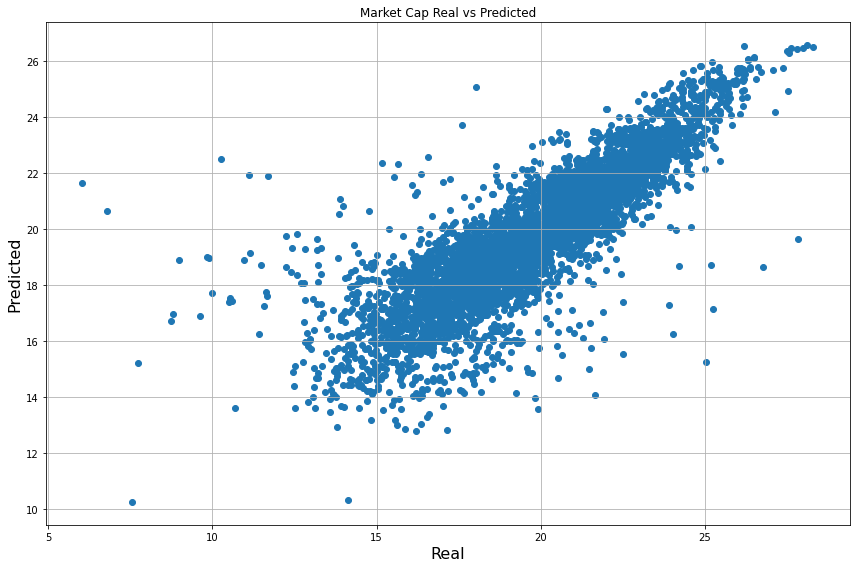

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Market Cap Real vs Predicted')
plt.xlabel('Real', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.scatter(logy_test, blended_log_df['BlendedPrediction'])
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

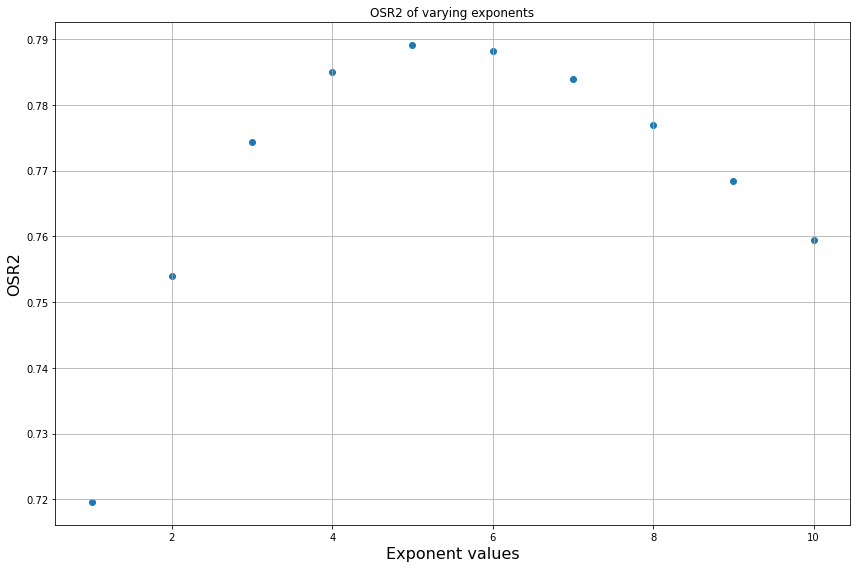

In [ ]:
# determine exponent (graphically) that will yield highest OSR^2 with an exponential transformation of the data
plt.figure(figsize=(12, 8))
plt.title('OSR2 of varying exponents')
plt.xlabel('Exponent values', fontsize=16)
plt.ylabel('OSR2', fontsize=16)
plt.scatter([i for i in range(1, 11)], [OSR2_no_model(blended_log_df['BlendedPrediction']**i, logy_test**i, logy_train**i) for i in range(1, 11)])
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

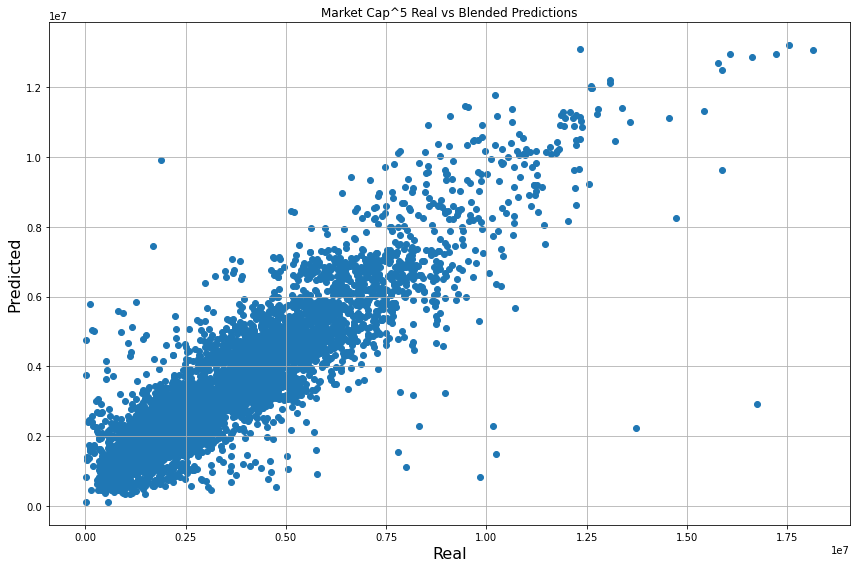

In [ ]:
# Eyeballing the above graph, looks like exponent of 5 yields highest OSR2
plt.figure(figsize=(12, 8))
plt.title('Market Cap^5 Real vs Blended Predictions')
plt.xlabel('Real', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.scatter(logy_test**5, blended_log_df['BlendedPrediction']**5)
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

In [ ]:
# Maximum OSR^2 among all models of 0.790 is achieved

osr2_blended_5 = OSR2_no_model(blended_log_df['BlendedPrediction']**5, logy_test**5, logy_train**5)
mse_blended_5 = MSE_no_model(blended_log_df['BlendedPrediction']**5, logy_test**5)
mae_blended_5 = MAE_no_model(blended_log_df['BlendedPrediction']**5, logy_test**5)
osr2_blended_5, mse_blended_5, mae_blended_5

(0.7890556532042947, 1203274976815.533, 767460.000721246)

In [ ]:
# compute Blended^5 row of results table

results_table = results_table.append({'OSR2': osr2_blended_5, 'MSE': "{:.3e}".format(mse_blended_5), 'MAE': "{:.3e}".format(mae_blended_5)}, ignore_index=True)
results_table['Model'] = pd.Series(data=['LinearRegression', 'CART', 'RandomForests', 'Blended', 'Blended^5'])
results_table = results_table.set_index('Model')
results_table = results_table.round(3)
results_table = results_table.drop_duplicates()
results_table

,OSR2,MSE,MAE
Model,,,
LinearRegression,0.621,2.932,1.252
CART,0.659,2.638,1.137
RandomForests,0.658,2.639,1.118
Blended,0.720,2.167,1.003
Blended^5,0.789,1.203e+12,7.675e+05
